Edge Detection - Thực hiện một số kỹ thuật phát hiện biên trên ảnh

In [1]:
from IPython.display import Image

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

## Câu 1:
Viết hàm sử dụng phương pháp gradient (bằng hàm có sẵn) và dùng toán tử  Sobel/Prewitt  để tính đạo hàm.
Sử dụng kết quả trên và Canny để phát hiện đường bao cho một ảnh bất kỳ.
Kiểm tra sự ổn định của hai phương pháp trên toàn bô số ảnh hạt thóc trong thư mục
hiện thời. Nhận xét kết quả đạt được (tỉ lệ thành công của mỗi phương pháp).


### 1.1 Sobel Edge Detection
Thư viện OpenCV cung cấp hàm cv2.Sobel() để tính đạo hàm của ảnh theo từng hướng sử dụng mặt nạ Sobel. Để phát hiện biên tốt, nên làm mịn ảnh trước để loại nhiễu. Ví dụ: có thể làm mịn với bộ lọc Gauss (cv2.GaussianBlur()) hoặc các bộ lọc phù hợp khác.

cv2.Sobel(): https://docs.opencv.org/4.5.2/d4/d86/group__imgproc__filter.html#gacea54f142e81b6758cb6f375ce782c8d

cv2.GaussianBlur(): https://docs.opencv.org/4.5.2/d4/d86/group__imgproc__filter.html#gaabe8c836e97159a9193fb0b11ac52cf1

Độ lớn của đạo hàm có thể được tính xấp xỉ bằng cách cộng giá trị tuyệt đối của đạo hàm theo 2 hướng. Tại vị trí biên, độ lớn của đạo hàm đạt cực đại ==> có thể dùng ngưỡng để xác định biên.

In [2]:
def basic_sobel_edge_detection(image_path, blur_ksize=5, sobel_ksize=1, skipping_threshold=30):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gaussian = cv2.GaussianBlur(gray,(blur_ksize,blur_ksize),0)

    #sobel
    img_sobelx = cv2.Sobel(img_gaussian,cv2.CV_8U,1,0,ksize=sobel_ksize) # output của phép nhân chập: số nguyên
    img_sobely = cv2.Sobel(img_gaussian,cv2.CV_8U,0,1,ksize=sobel_ksize) # ksize = 1: mặt nạ 1x3 hoặc 3x1 được dùng, không có Gaussian

    img_sobel = (img_sobelx + img_sobely)/2
    for i in range(img_sobel.shape[0]):
        for j in range(img_sobel.shape[1]):
            if img_sobel[i][j] < skipping_threshold:
                img_sobel[i][j] = 0
            else:
                img_sobel[i][j] = 255
    return img_sobel

Ta thử chạy hàm với một ảnh trong bộ dữ liệu và xem kết quả

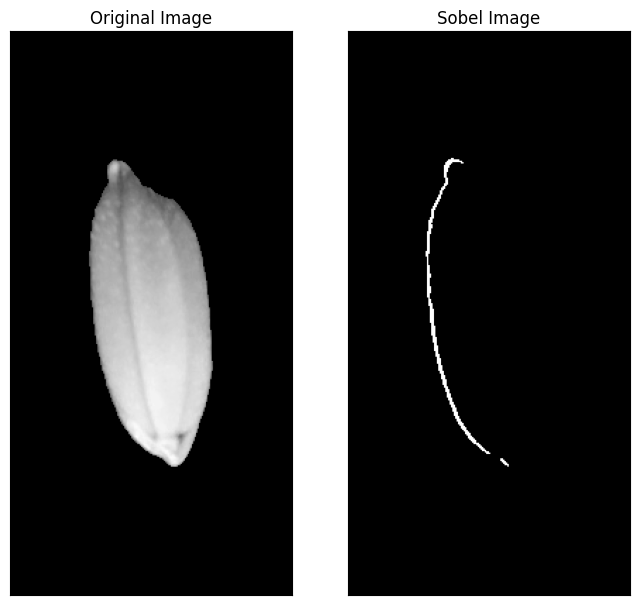

In [3]:
image_path = 'images/seed.png'
gray = cv2.imread(image_path, 0)
img_sobel = basic_sobel_edge_detection(image_path, 5, 1, 30)

plt.figure(figsize=(8,8))
plt.subplot(121),plt.imshow(gray, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_sobel,cmap = 'gray')
plt.title('Sobel Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [4]:
# phát hiện biên sử dụng
def sobel_edge_detection(image_path, blur_ksize=5, sobel_ksize=1, skipping_threshold=30):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gaussian = cv2.GaussianBlur(gray,(blur_ksize,blur_ksize),0)

    sobelx64f = cv2.Sobel(img_gaussian,cv2.CV_64F,1,0,ksize=sobel_ksize) # output của phép nhân chập: : số thực
    abs_sobel64f = np.absolute(sobelx64f)
    img_sobelx = np.uint8(abs_sobel64f)

    sobely64f = cv2.Sobel(img_gaussian,cv2.CV_64F,0,1,ksize=sobel_ksize) # output của phép nhân chập: : số thực
    abs_sobel64f = np.absolute(sobely64f)
    img_sobely = np.uint8(abs_sobel64f)

    img_sobel = (img_sobelx + img_sobely)/2
    for i in range(img_sobel.shape[0]):
        for j in range(img_sobel.shape[1]):
            if img_sobel[i][j] < skipping_threshold:
                img_sobel[i][j] = 0
            else:
                img_sobel[i][j] = 255
    return img_sobel

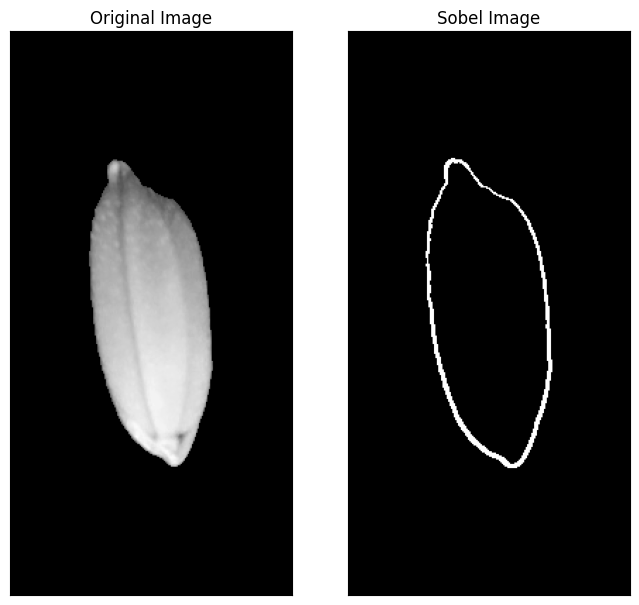

In [5]:
image_path = 'images/seed.png'
gray = cv2.imread(image_path, 0)
img_sobel = sobel_edge_detection(image_path, 5, 1, 30)

plt.figure(figsize=(8,8))
plt.subplot(121),plt.imshow(gray, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_sobel,cmap = 'gray')
plt.title('Sobel Image'), plt.xticks([]), plt.yticks([])
plt.show()

### 1.2. Prewitt Edge Detection
Khi lọc với bộ lọc không được định nghĩa trước, có thể dùng hàm cv2.filter2D() để thực hiện với các mặt nạ mong muốn.
Ở đây nếu ta muốn sử dụng mặt nạ Prewitt để tính đạo hàm thì cần truyền tham số kernel của filter2D tương ứng chính là mặt nạ Prewitt.

Ta sẽ tính 2 trường hợp cạnh black-to-white và white-to-black rồi tính trung bình cộng 2 kết quả.

Cuối cùng đặt ngưỡng loại bỏ nhiễu.

In [13]:
def prewitt_edge_detection(image_path, blur_ksize = 5, skipping_threshold=30):
    ### YOUR CODE HERE ###
    # Làm mờ ảnh để giảm nhiễu
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blurred_image = cv2.GaussianBlur(image, (blur_ksize, blur_ksize), 0)

    # Tính toán toán tử Prewitt
    kernel_x = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]], dtype=np.float32)
    kernel_y = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]], dtype=np.float32)

    prewitt_x = cv2.filter2D(blurred_image, cv2.CV_64F, kernel_x)
    prewitt_y = cv2.filter2D(blurred_image, cv2.CV_64F, kernel_y)
    prewitt_magnitude = cv2.magnitude(prewitt_x, prewitt_y)

    # Chuẩn hóa và ngưỡng hóa
    prewitt_edges = np.uint8(prewitt_magnitude)
    prewitt_edges[prewitt_edges < skipping_threshold] = 0

    return prewitt_edges

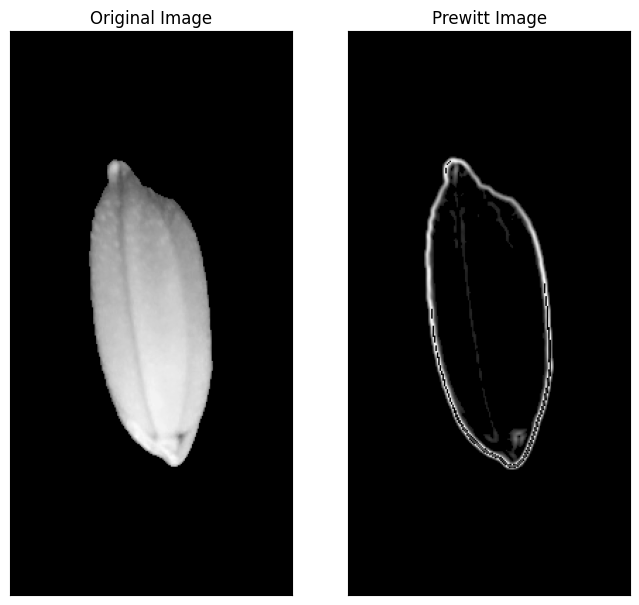

In [ ]:
image_path = 'images/seed.png'
gray = cv2.imread(image_path, 0)
img_prewitt = prewitt_edge_detection(image_path, 5, 30)

plt.figure(figsize=(8,8))
plt.subplot(121),plt.imshow(gray, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_prewitt,cmap = 'gray')
plt.title('Prewitt Image'), plt.xticks([]), plt.yticks([])
plt.show()

### 1.3. Canny Edge Detection
Thư viện OpenCV cung cấp hàm cv2.Canny() để phát hiện biên bằng thuật toán Canny.

https://docs.opencv.org/4.5.2/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de

Tương tự như các phương pháp phát hiện biên ở trên, trước hết ta cũng dùng cv2.GaussianBlur() để làm mịn ảnh rồi sử dụng Canny để phát hiện biên.

In [ ]:
def canny_edge_detection(image_path, blur_ksize=5, threshold1=100, threshold2=200):
    # Đọc ảnh xám
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Làm mờ ảnh để giảm nhiễu
    blurred_image = cv2.GaussianBlur(image, (blur_ksize, blur_ksize), 0)

    # Áp dụng bộ lọc Canny
    canny_edges = cv2.Canny(blurred_image, threshold1, threshold2)

    return canny_edges

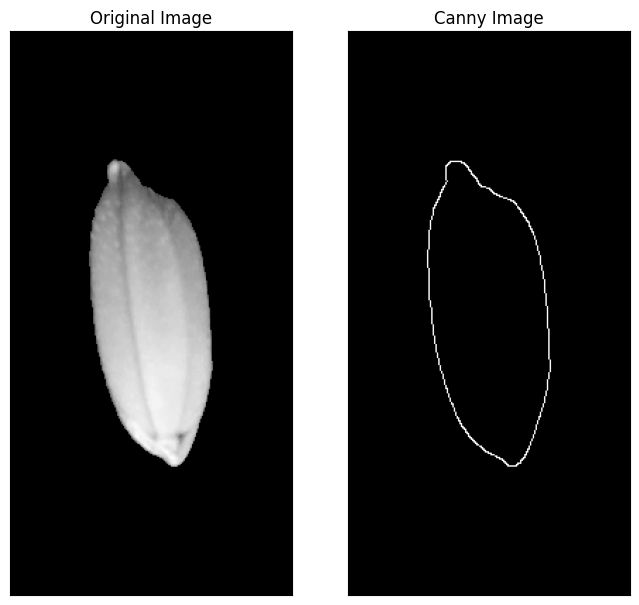

In [ ]:
image_path = 'images/seed.png'
gray = cv2.imread(image_path, 0)
img_canny = canny_edge_detection(image_path, 7, 100, 200)

plt.figure(figsize=(8,8))
plt.subplot(121),plt.imshow(gray, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_canny,cmap = 'gray')
plt.title('Canny Image'), plt.xticks([]), plt.yticks([])
plt.show()

### Hãy thay đổi các tham số cần thiết để thu được kết quả tốt nhất ở mỗi phương pháp

## Câu 3:
Đếm số pixel trên mỗi đường bao (chu vi) từ kết quả câu 2. Vẽ phân bố vể chu vi các ảnh (sử dụng chung tập dữ liệu gồm 1 số ảnh trong thư mục subdata). Nhận xét sự khác biệt giữa hai phân bố khi dùng kết quả của các phương pháp phát hiện biên tương ứng.

### Phân bố của Sobel edge detection

In [ ]:
image_dir = 'subdata/'
list_c = []
for file in os.listdir(image_dir):
    image_path = os.path.join(image_dir, file)
    skipping_threshold = 30
    img_sobel = sobel_edge_detection(image_path, skipping_threshold=skipping_threshold) # phát hiện biên
    chuvi = 0
    for i in range(img_sobel.shape[0]): # đếm số điểm biên cho mỗi ảnh
        for j in range(img_sobel.shape[1]):
            if img_sobel[i][j] >= skipping_threshold:
                chuvi += 1
    list_c.append(chuvi)
plt.hist(list_c, 30, [0, 4000]); plt.show() # hiển thị phân bố số điểm biên trên tập ảnh

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'subdata/'

### Phân bố của Prewitt edge detectimon

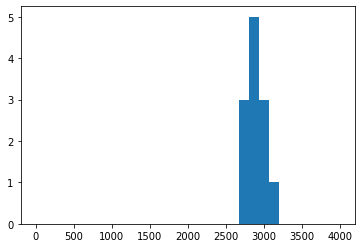

In [ ]:
image_dir = 'subdata/'
list_c = []
### YOUR CODE HERE ###


### YOUR CODE HERE ###
plt.hist(list_c, 30, [0, 4000]); plt.show()

### Phân bố của Canny edge detection

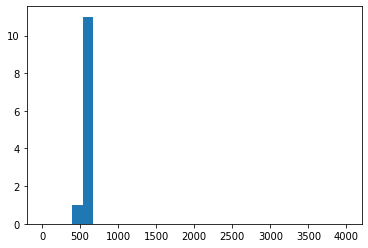

In [ ]:
image_dir = 'subdata/'
list_c = []
### YOUR CODE HERE ###


### YOUR CODE HERE ###
plt.hist(list_c, 30, [0, 4000]); plt.show()

## Câu 4:
Phát hiện làn đường: Dùng các phương pháp phát hiện biên ở trên để phát hiện làn đường trong các trường hợp sau

### 4.1: Làn đường thẳng

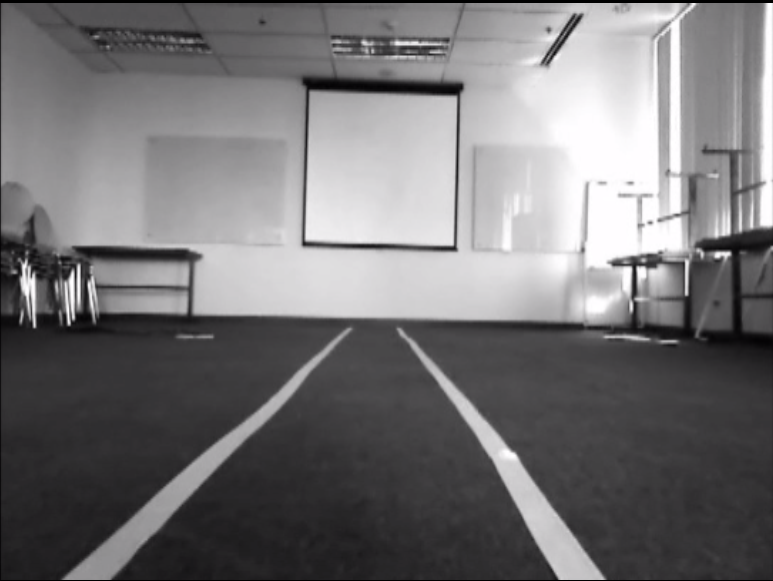

In [27]:
Image('./lane_detection/lane1.png')

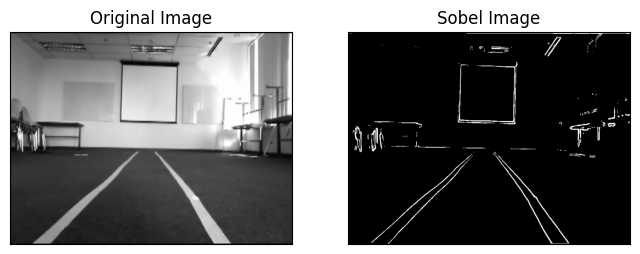

In [30]:
# Sử dụng phương pháp Sobel tìm biên và hiển thị kết quả
### YOUR CODE HERE ###

image_path = './lane_detection/lane1.png'
gray = cv2.imread(image_path, 0)
img_sobel = sobel_edge_detection(image_path, 5, 1, 30)

plt.figure(figsize=(8,8))
plt.subplot(121),plt.imshow(gray, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_sobel,cmap = 'gray')
plt.title('Sobel Image'), plt.xticks([]), plt.yticks([])
plt.show()
### YOUR CODE HERE ###

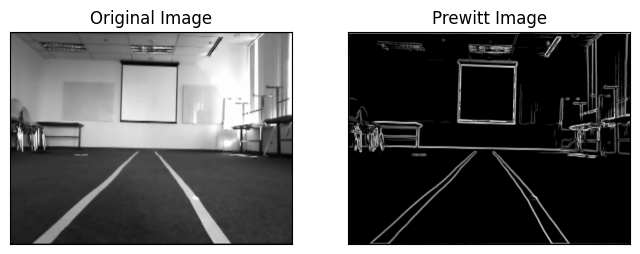

In [31]:
# Sử dụng phương pháp Prewitt tìm biên và hiển thị kết quả
### YOUR CODE HERE ###
image_path = './lane_detection/lane1.png'
gray = cv2.imread(image_path, 0)
img_prewitt = prewitt_edge_detection(image_path, 5, 30)

plt.figure(figsize=(8,8))
plt.subplot(121),plt.imshow(gray, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_prewitt,cmap = 'gray')
plt.title('Prewitt Image'), plt.xticks([]), plt.yticks([])
plt.show()

### YOUR CODE HERE ###

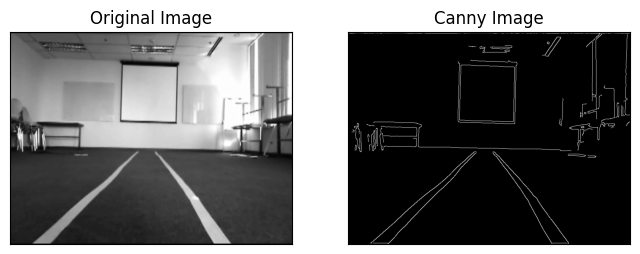

In [32]:
# Sử dụng phương pháp Canny tìm biên và hiển thị kết quả
### YOUR CODE HERE ###

image_path = './lane_detection/lane1.png'
gray = cv2.imread(image_path, 0)
img_canny = canny_edge_detection(image_path, 7, 100, 200)

plt.figure(figsize=(8,8))
plt.subplot(121),plt.imshow(gray, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_canny,cmap = 'gray')
plt.title('Canny Image'), plt.xticks([]), plt.yticks([])
plt.show()
### YOUR CODE HERE ###

### 4.2: Làn đường cong

Hãy đánh giá và thử các chiến lược phát hiện biên khác nhau trên các ảnh sau.  Lưu ý ảnh hưởng của tham số và các phương pháp khác nhau đến kết quả cuối cùng.

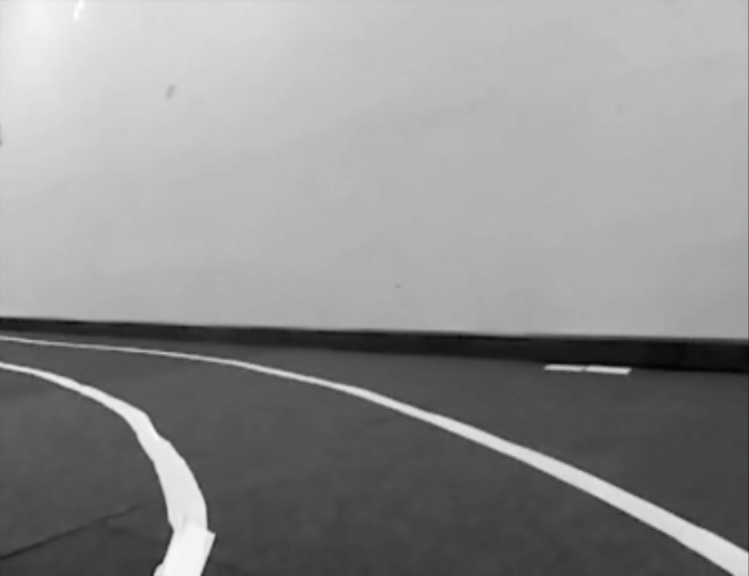

In [33]:
Image('./lane_detection/lane2.png')

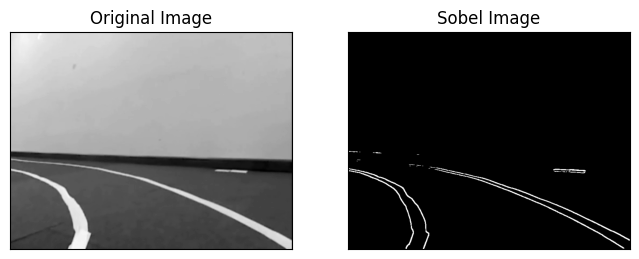

In [37]:
### YOUR CODE HERE ###
image_path = './lane_detection/lane2.png'
gray = cv2.imread(image_path, 0)
img_sobel = sobel_edge_detection(image_path, 5, 1, 30)

plt.figure(figsize=(8,8))
plt.subplot(121),plt.imshow(gray, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_sobel,cmap = 'gray')
plt.title('Sobel Image'), plt.xticks([]), plt.yticks([])
plt.show()



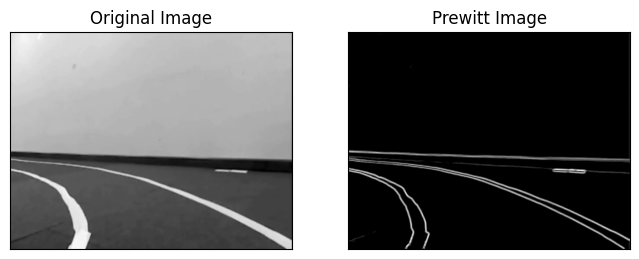

In [35]:
### YOUR CODE HERE ###

image_path = './lane_detection/lane2.png'
gray = cv2.imread(image_path, 0)
img_prewitt = prewitt_edge_detection(image_path, 5, 30)

plt.figure(figsize=(8,8))
plt.subplot(121),plt.imshow(gray, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_prewitt,cmap = 'gray')
plt.title('Prewitt Image'), plt.xticks([]), plt.yticks([])
plt.show()

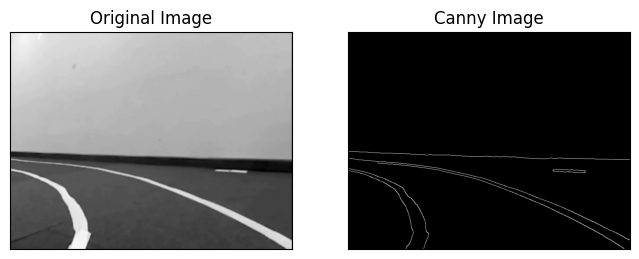

In [34]:
### YOUR CODE HERE ###
image_path = './lane_detection/lane2.png'
gray = cv2.imread(image_path, 0)
img_canny = canny_edge_detection(image_path, 7, 100, 200)

plt.figure(figsize=(8,8))
plt.subplot(121),plt.imshow(gray, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_canny,cmap = 'gray')
plt.title('Canny Image'), plt.xticks([]), plt.yticks([])
plt.show()


### 4.3: Làn đường bóng, có nhiễu do phản chiếu

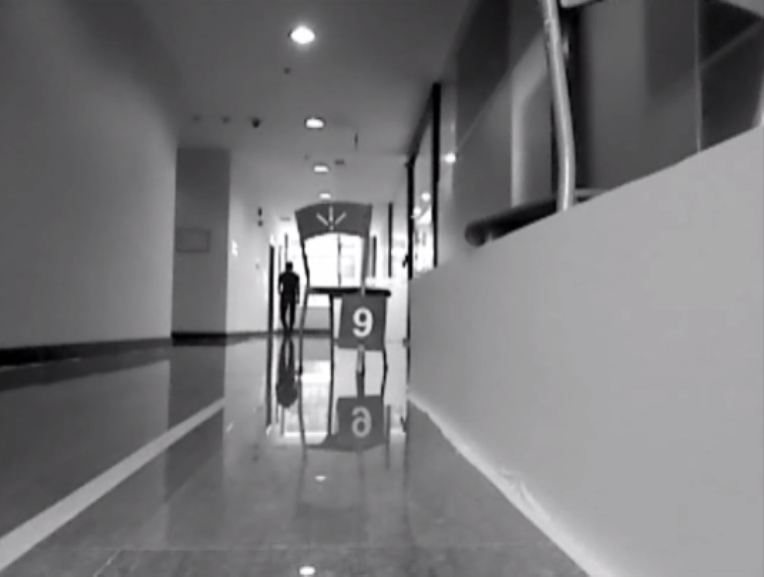

In [38]:
Image('./lane_detection/lane3.png')

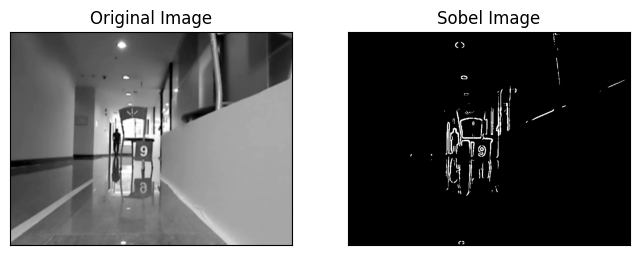

In [39]:
### YOUR CODE HERE ###

image_path = './lane_detection/lane3.png'
gray = cv2.imread(image_path, 0)
img_sobel = sobel_edge_detection(image_path, 5, 1, 30)

plt.figure(figsize=(8,8))
plt.subplot(121),plt.imshow(gray, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_sobel,cmap = 'gray')
plt.title('Sobel Image'), plt.xticks([]), plt.yticks([])
plt.show()

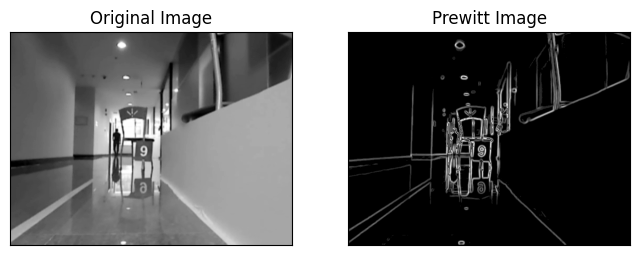

In [40]:
### YOUR CODE HERE ###
image_path = './lane_detection/lane3.png'
gray = cv2.imread(image_path, 0)
img_prewitt = prewitt_edge_detection(image_path, 5, 30)

plt.figure(figsize=(8,8))
plt.subplot(121),plt.imshow(gray, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_prewitt,cmap = 'gray')
plt.title('Prewitt Image'), plt.xticks([]), plt.yticks([])
plt.show()


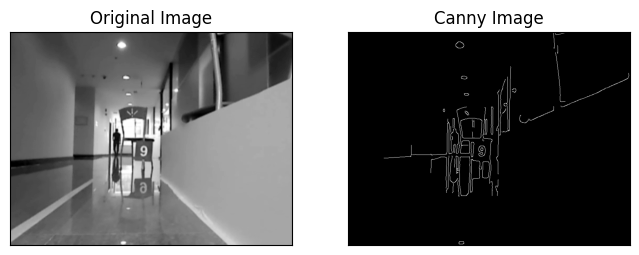

In [41]:
### YOUR CODE HERE ###
image_path = './lane_detection/lane3.png'
gray = cv2.imread(image_path, 0)
img_canny = canny_edge_detection(image_path, 7, 100, 200)

plt.figure(figsize=(8,8))
plt.subplot(121),plt.imshow(gray, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_canny,cmap = 'gray')
plt.title('Canny Image'), plt.xticks([]), plt.yticks([])
plt.show()


## Tính và hiển thị đạo hàm bậc hai của ảnh
Hàm tham khảo:
https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#gad78703e4c8fe703d479c1860d76429e6

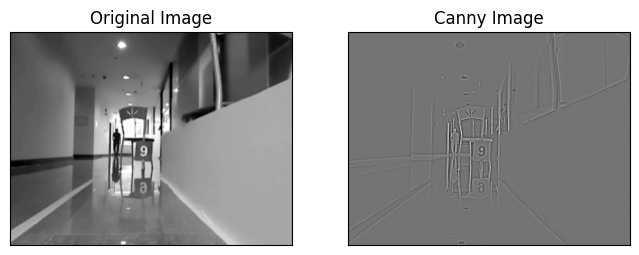

In [46]:
### YOUR CODE HERE ###

def second_derivative(image_path, ddepth=cv2.CV_64F, ksize=5):
    # Đọc ảnh xám
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Tính đạo hàm bậc hai (Laplacian)
    laplacian_image = cv2.Laplacian(image, ddepth, ksize=ksize)

    # Chuẩn hóa ảnh để hiển thị
    # laplacian_image = cv2.convertScaleAbs(laplacian_image)

    return laplacian_image

# Ví dụ sử dụng
image_path = './lane_detection/lane3.png'
gray = cv2.imread(image_path, 0)
laplacian_result = second_derivative(image_path)

plt.figure(figsize=(8,8))
plt.subplot(121),plt.imshow(gray, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(laplacian_result,cmap = 'gray')
plt.title('Canny Image'), plt.xticks([]), plt.yticks([])
plt.show()
